# 02 — Modeling

Model training and evaluation notebook for S2Cool using preprocessed data (default) with optional raw DB refetch.

In [2]:
# CELL 1: Data Source Selection (default: local processed CSV, optional DB refetch)
from __future__ import annotations

import os
from pathlib import Path
from typing import Final

import pandas as pd

REFETCH_FROM_DB: Final[bool] = False
PROCESSED_BACKUP_PATH: Final[Path] = Path("data/s2cool_features_ready.csv")

raw_df: pd.DataFrame | None = None
processed_for_csv: pd.DataFrame | None = None

if (not REFETCH_FROM_DB) and PROCESSED_BACKUP_PATH.exists():
    processed_for_csv = pd.read_csv(PROCESSED_BACKUP_PATH)
    if processed_for_csv.empty:
        raise ValueError(f"Processed CSV exists but is empty: {PROCESSED_BACKUP_PATH}")

    if "Timestamp" not in processed_for_csv.columns:
        raise KeyError("Processed CSV must include a 'Timestamp' column.")

    processed_for_csv["Timestamp"] = pd.to_datetime(
        processed_for_csv["Timestamp"], errors="coerce", utc=True
    )
    if processed_for_csv["Timestamp"].isna().any():
        raise ValueError("Failed to parse one or more Timestamp values from processed CSV.")

    print(f"Loaded existing processed data from: {PROCESSED_BACKUP_PATH}")
    print(f"Processed CSV shape: {processed_for_csv.shape}")
else:
    from dotenv import load_dotenv
    from sqlalchemy import create_engine, text
    from sqlalchemy.engine import Engine
    from sqlalchemy.exc import SQLAlchemyError

    load_dotenv()
    database_url: str | None = os.getenv("DATABASE_URL") or os.getenv("NEON_DB_URL")
    if not database_url:
        raise RuntimeError("Missing required environment variable: DATABASE_URL or NEON_DB_URL")

    def create_db_engine(db_url: str) -> Engine:
        """Create SQLAlchemy engine with pool health checks."""
        return create_engine(db_url, pool_pre_ping=True)

    def detect_weather_table(engine: Engine) -> str:
        """Detect expected weather table name in current schema."""
        query = text(
            """
            SELECT table_name
            FROM information_schema.tables
            WHERE table_schema = 'public'
              AND table_name IN ('solar_weather_data', 'weather_data')
            ORDER BY CASE WHEN table_name = 'solar_weather_data' THEN 0 ELSE 1 END
            LIMIT 1;
            """
        )
        with engine.connect() as connection:
            table_name = connection.execute(query).scalar_one_or_none()
        if table_name is None:
            raise RuntimeError(
                "No expected weather table found. Expected one of: solar_weather_data, weather_data"
            )
        return str(table_name)

    def fetch_raw_weather_dataframe(engine: Engine, table_name: str) -> pd.DataFrame:
        """Fetch normalized weather columns ordered by city and timestamp."""
        if table_name == "solar_weather_data":
            query = text(
                """
                SELECT
                    timestamp AS \"Timestamp\",
                    city_name AS \"City\",
                    shortwave_radiation AS \"GHI\",
                    temperature_2m AS \"Ambient_Temp\"
                FROM solar_weather_data
                ORDER BY city_name ASC, timestamp ASC;
                """
            )
        else:
            query = text(
                """
                SELECT
                    timestamp AS \"Timestamp\",
                    city AS \"City\",
                    ghi AS \"GHI\",
                    ambient_temp AS \"Ambient_Temp\"
                FROM weather_data
                ORDER BY city ASC, timestamp ASC;
                """
            )

        with engine.connect() as connection:
            return pd.read_sql_query(query, con=connection)

    try:
        db_engine = create_db_engine(database_url)
        table_name = detect_weather_table(db_engine)
        print(f"Using source table: {table_name}")
        raw_df = fetch_raw_weather_dataframe(db_engine, table_name)
    except SQLAlchemyError as exc:
        raise RuntimeError(
            "Database connection/query failed for weather extraction."
        ) from exc

    if raw_df.empty:
        raise ValueError("Weather query returned zero rows.")

    print(f"Raw dataframe shape: {raw_df.shape}")
    print("Raw dataframe columns:", list(raw_df.columns))

if raw_df is not None:
    raw_df.head()
else:
    processed_for_csv.head()

Using source table: solar_weather_data
Raw dataframe shape: (35644, 4)
Raw dataframe columns: ['Timestamp', 'City', 'GHI', 'Ambient_Temp']


In [3]:
# CELL 2: Preprocessing Integration (only when raw DB data is fetched)
from preprocessing import S2CoolDataPreprocessor

if raw_df is not None:
    required_columns = {"Timestamp", "City", "GHI", "Ambient_Temp"}
    column_mapping = {
        "timestamp": "Timestamp",
        "city": "City",
        "ghi": "GHI",
        "ambient_temp": "Ambient_Temp",
        "temperature_2m": "Ambient_Temp",
        "shortwave_radiation": "GHI",
    }
    normalized_raw_df = raw_df.rename(columns=column_mapping).copy()
    missing_after_map = required_columns - set(normalized_raw_df.columns)
    if missing_after_map:
        raise KeyError(f"Missing required columns after normalization: {sorted(missing_after_map)}")

    processor = S2CoolDataPreprocessor(
        scaler_path=Path("artifacts/s2cool_standard_scaler.joblib")
    )
    processed_df = processor.process_pipeline(normalized_raw_df)

    processed_backup_path = Path("data/s2cool_features_ready.csv")
    processed_backup_path.parent.mkdir(parents=True, exist_ok=True)
    processed_for_csv = processed_df.reset_index().rename(columns={"index": "Timestamp"})
    processed_for_csv.to_csv(processed_backup_path, index=False)

    print(f"Processed dataframe shape: {processed_df.shape}")
    print(f"Saved processed backup to: {processed_backup_path}")
else:
    if processed_for_csv is None:
        raise RuntimeError("No data available for modeling. Enable REFETCH_FROM_DB or provide processed CSV.")

    processed_df = processed_for_csv.copy()
    processed_df["Timestamp"] = pd.to_datetime(processed_df["Timestamp"], errors="coerce", utc=True)
    if processed_df["Timestamp"].isna().any():
        raise ValueError("Timestamp parsing failed for processed CSV loaded in CELL 1.")

    processed_df = processed_df.set_index("Timestamp")
    print(f"Using preprocessed dataframe from local CSV. Shape: {processed_df.shape}")

processed_df.head()

Processed dataframe shape: (35640, 23)
Saved processed backup to: data\s2cool_features_ready.csv


,City,GHI,Ambient_Temp,day_of_year,hour_sin,hour_cos,month_sin,month_cos,GHI_lag_1,GHI_lag_2,...,Ambient_Temp_lag_1,Ambient_Temp_lag_2,Ambient_Temp_lag_3,Ambient_Temp_lag_24,Ambient_Temp_lag_48,GHI_rolling_mean_3h,GHI_rolling_std_3h,Temp_rolling_mean_6h,Target_GHI_next_1h,Target_Temp_next_1h
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-22 05:00:00+05:00,Islamabad,0.0,-1.659441,53,0.965926,2.588190e-01,0.866025,0.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.7
2025-02-22 06:00:00+05:00,Islamabad,0.0,-1.597798,53,1.000000,6.123234e-17,0.866025,0.5,-0.741132,NaN,...,-1.659378,NaN,NaN,NaN,NaN,-0.770299,NaN,-1.700462,1.0,10.2
2025-02-22 07:00:00+05:00,Islamabad,1.0,-1.659441,53,0.965926,-2.588190e-01,0.866025,0.5,-0.741132,-0.741049,...,-1.597738,-1.659365,NaN,NaN,NaN,-0.770299,-0.898652,-1.668876,80.0,11.6
2025-02-22 08:00:00+05:00,Islamabad,80.0,-1.486841,53,0.866025,-5.000000e-01,0.866025,0.5,-0.737414,-0.741049,...,-1.659378,-1.597727,-1.659444,NaN,NaN,-0.769010,-0.890024,-1.679405,252.0,14.6
2025-02-22 09:00:00+05:00,Islamabad,252.0,-1.116984,53,0.707107,-7.071068e-01,0.866025,0.5,-0.443646,-0.737330,...,-1.486786,-1.659365,-1.597807,NaN,NaN,-0.665931,-0.212657,-1.640448,431.0,17.0


In [4]:
# CELL 3: Strict Time-Series Splitting
target_columns = ['Target_GHI_next_1h', 'Target_Temp_next_1h']

processed_sorted = processed_df.reset_index().rename(columns={'index': 'Timestamp'}).copy()
processed_sorted['Timestamp'] = pd.to_datetime(processed_sorted['Timestamp'], errors='coerce', utc=True)
if processed_sorted['Timestamp'].isna().any():
    raise ValueError('Timestamp parsing failed in processed dataframe prior to split.')
processed_sorted = processed_sorted.sort_values('Timestamp').reset_index(drop=True)

missing_targets = [c for c in target_columns if c not in processed_sorted.columns]
if missing_targets:
    raise KeyError(f'Missing target columns for split: {missing_targets}')

X = processed_sorted.drop(columns=target_columns).copy()
y = processed_sorted[target_columns].copy()

# Convert feature columns to model-safe numeric matrix while preserving chronology.
if 'Timestamp' in X.columns:
    X['Timestamp'] = pd.to_datetime(X['Timestamp'], utc=True).astype('int64') // 10**9
if 'City' in X.columns:
    X['City'] = X['City'].astype('category')
    X = pd.get_dummies(X, columns=['City'], dtype=float)

X = X.apply(pd.to_numeric, errors='coerce').fillna(0.0)

split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index].copy()
X_test = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index].copy()
y_test = y.iloc[split_index:].copy()

print(f'Chronologically sorted dataframe shape: {processed_sorted.shape}')
print(f'X shape: {X.shape} | y shape: {y.shape}')
print(f'X_train shape: {X_train.shape} | X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} | y_test shape: {y_test.shape}')

Chronologically sorted dataframe shape: (35640, 24)
X shape: (35640, 25) | y shape: (35640, 2)
X_train shape: (28512, 25) | X_test shape: (7128, 25)
y_train shape: (28512, 2) | y_test shape: (7128, 2)


In [5]:
# CELL 4: Model 1 - XGBoost (Robust Baseline)
from pathlib import Path

import joblib
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_train_ghi = y_train['Target_GHI_next_1h'].to_numpy()
y_test_ghi = y_test['Target_GHI_next_1h'].to_numpy()

print(f'XGB train matrix shape: {X_train.shape}')
print(f'XGB test matrix shape: {X_test.shape}')
print(f'y_train_ghi shape: {y_train_ghi.shape} | y_test_ghi shape: {y_test_ghi.shape}')

xgb_model = xgb.XGBRegressor(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)
xgb_model.fit(X_train, y_train_ghi)

xgb_preds = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test_ghi, xgb_preds)
xgb_rmse = float(np.sqrt(mean_squared_error(y_test_ghi, xgb_preds)))

print(f'XGBoost MAE:  {xgb_mae:.4f}')
print(f'XGBoost RMSE: {xgb_rmse:.4f}')

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(parents=True, exist_ok=True)
xgb_model_path = artifacts_dir / 'xgboost_ghi_model.pkl'
joblib.dump(xgb_model, xgb_model_path)
print(f'Saved XGBoost model to: {xgb_model_path}')

XGB train matrix shape: (28512, 25)
XGB test matrix shape: (7128, 25)
y_train_ghi shape: (28512,) | y_test_ghi shape: (7128,)
XGBoost MAE:  13.6723
XGBoost RMSE: 26.1027
Saved XGBoost model to: artifacts\xgboost_ghi_model.pkl


In [6]:
# CELL 5: Model 2 - LSTM (Deep Learning Challenger)
from pathlib import Path

import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

X_train_lstm = X_train.to_numpy(dtype=np.float32).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.to_numpy(dtype=np.float32).reshape((X_test.shape[0], 1, X_test.shape[1]))

y_train_lstm = y_train['Target_GHI_next_1h'].to_numpy(dtype=np.float32)
y_test_lstm = y_test['Target_GHI_next_1h'].to_numpy(dtype=np.float32)

print(f'X_train_lstm shape: {X_train_lstm.shape}')
print(f'X_test_lstm shape: {X_test_lstm.shape}')
print(f'y_train_lstm shape: {y_train_lstm.shape} | y_test_lstm shape: {y_test_lstm.shape}')

tf.random.set_seed(42)

lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    Dense(1),
])
lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=10,
    batch_size=32,
    verbose=1,
)

lstm_preds = lstm_model.predict(X_test_lstm, verbose=0).reshape(-1)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_preds)
lstm_rmse = float(np.sqrt(mean_squared_error(y_test_lstm, lstm_preds)))

print(f'LSTM MAE:  {lstm_mae:.4f}')
print(f'LSTM RMSE: {lstm_rmse:.4f}')

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(parents=True, exist_ok=True)
lstm_model_path = artifacts_dir / 'lstm_ghi_model.keras'
lstm_model.save(lstm_model_path)
print(f'Saved LSTM model to: {lstm_model_path}')

X_train_lstm shape: (28512, 1, 25)
X_test_lstm shape: (7128, 1, 25)
y_train_lstm shape: (28512,) | y_test_lstm shape: (7128,)
Epoch 1/10


f:\Documents\MagicBox\magic\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 121338.4141 - val_loss: 66385.5078
Epoch 2/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 117575.2891 - val_loss: 63956.1094
Epoch 3/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 114043.3203 - val_loss: 61727.2422
Epoch 4/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - loss: 110735.9297 - val_loss: 59683.9102
Epoch 5/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 107602.5156 - val_loss: 57813.4414
Epoch 6/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 104686.2188 - val_loss: 56115.0156
Epoch 7/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 101935.6953 - val_loss: 54579.7383
Epoch 8/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 99312.0469 - val_loss: 53204.4883
Epoch 9/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 96923.0156 - val_loss: 51989.0156
Epoch 10/10
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - loss: 94626.6406 - val_loss: 50928.2148
LSTM MAE:  163.8033
LSTM RMSE: 225.6727
Saved LSTM model to

## CELL 6: Model Comparison Diagnostics

Compare XGBoost and LSTM on the same test horizon using:
- Predicted vs Actual trajectory plot
- Residual distribution plot
- Summary metric table (MAE, RMSE)

Artifacts are saved under `visualizations/`.

Comparison dataframe shape: (7128, 6)
                  Timestamp  Actual_GHI  XGBoost_Pred  LSTM_Pred  \
0 2025-12-16 00:00:00+00:00         0.0      0.148671   87.06842   
1 2025-12-16 00:00:00+00:00         0.0      0.148671   87.06842   
2 2025-12-16 00:00:00+00:00         0.0      0.653815   87.06842   
3 2025-12-16 00:00:00+00:00         0.0      0.609465   87.06842   
4 2025-12-16 01:00:00+00:00         0.0      2.860439   87.06842   

   XGB_Residual  LSTM_Residual  
0     -0.148671      -87.06842  
1     -0.148671      -87.06842  
2     -0.653815      -87.06842  
3     -0.609465      -87.06842  
4     -2.860439      -87.06842  


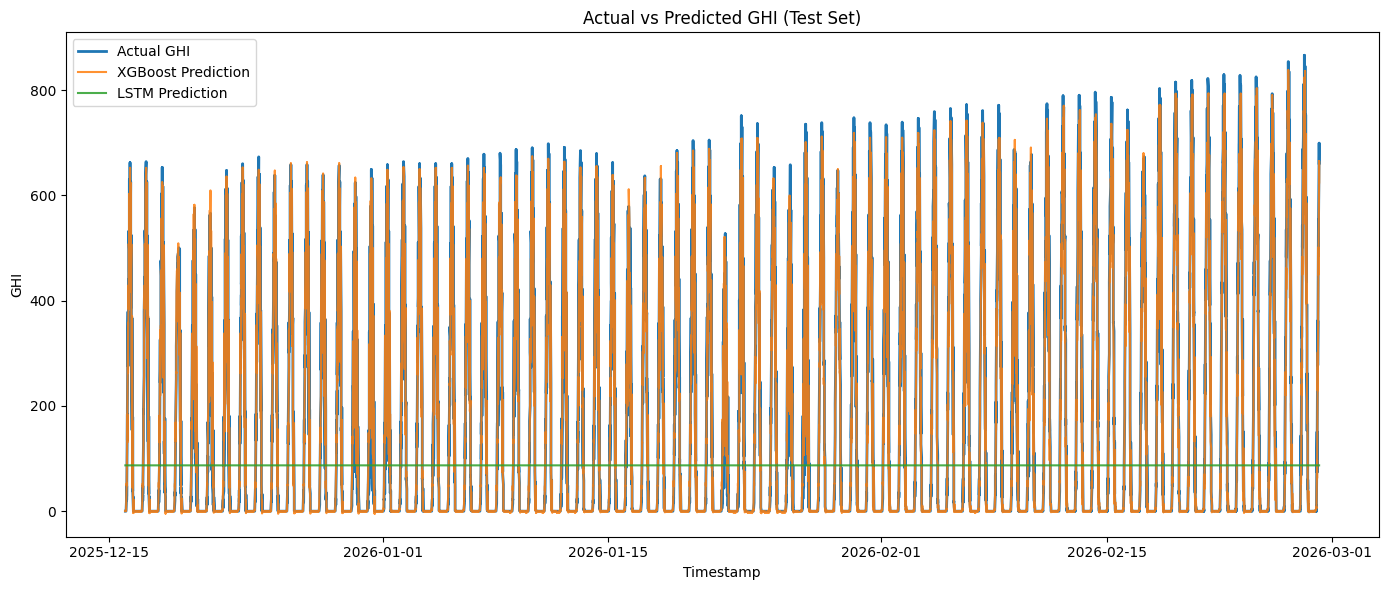

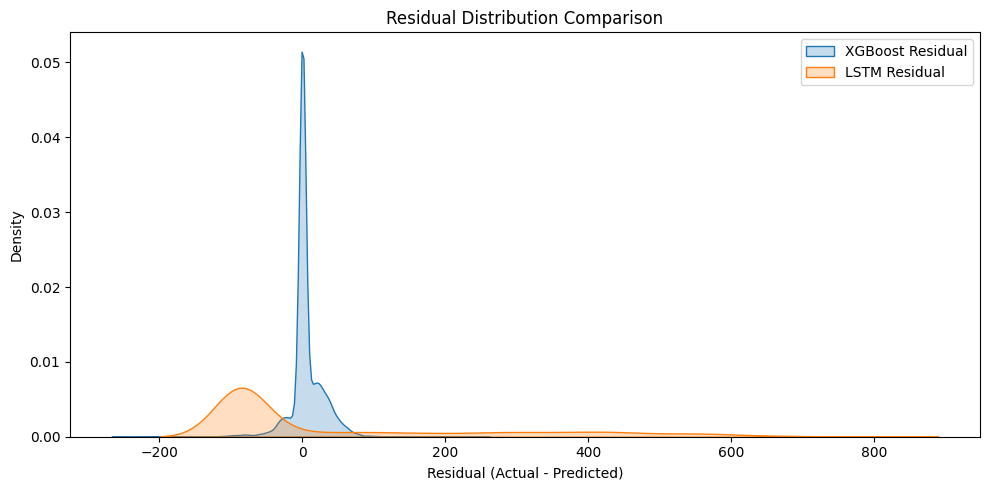


Model performance summary:
     Model         MAE        RMSE
0  XGBoost   13.672267   26.102681
1     LSTM  163.803268  225.672744

Saved comparison plots to: visualizations


In [7]:
# CELL 6 (Code): XGBoost vs LSTM diagnostics
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

viz_dir = Path("visualizations")
viz_dir.mkdir(parents=True, exist_ok=True)

comparison_df = pd.DataFrame(
    {
        "Timestamp": processed_sorted.loc[X_test.index, "Timestamp"].reset_index(drop=True),
        "Actual_GHI": pd.Series(y_test_ghi).reset_index(drop=True),
        "XGBoost_Pred": pd.Series(xgb_preds).reset_index(drop=True),
        "LSTM_Pred": pd.Series(lstm_preds).reset_index(drop=True),
    }
)

comparison_df["XGB_Residual"] = comparison_df["Actual_GHI"] - comparison_df["XGBoost_Pred"]
comparison_df["LSTM_Residual"] = comparison_df["Actual_GHI"] - comparison_df["LSTM_Pred"]

print(f"Comparison dataframe shape: {comparison_df.shape}")
print(comparison_df.head())

# Plot 1: Actual vs predictions
plt.figure(figsize=(14, 6))
plt.plot(comparison_df["Timestamp"], comparison_df["Actual_GHI"], label="Actual GHI", linewidth=2)
plt.plot(comparison_df["Timestamp"], comparison_df["XGBoost_Pred"], label="XGBoost Prediction", alpha=0.85)
plt.plot(comparison_df["Timestamp"], comparison_df["LSTM_Pred"], label="LSTM Prediction", alpha=0.85)
plt.title("Actual vs Predicted GHI (Test Set)")
plt.xlabel("Timestamp")
plt.ylabel("GHI")
plt.legend()
plt.tight_layout()
plt.savefig(viz_dir / "model_comparison_timeseries.png", dpi=300)
plt.show()

# Plot 2: Residual distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(comparison_df["XGB_Residual"], label="XGBoost Residual", fill=True)
sns.kdeplot(comparison_df["LSTM_Residual"], label="LSTM Residual", fill=True)
plt.title("Residual Distribution Comparison")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(viz_dir / "model_comparison_residuals.png", dpi=300)
plt.show()

summary_metrics = pd.DataFrame(
    [
        {"Model": "XGBoost", "MAE": float(xgb_mae), "RMSE": float(xgb_rmse)},
        {"Model": "LSTM", "MAE": float(lstm_mae), "RMSE": float(lstm_rmse)},
    ]
)

print("\nModel performance summary:")
print(summary_metrics)
print(f"\nSaved comparison plots to: {viz_dir}")